#                  Analiza danych dotyczących cen nieruchomości



Krok 1: Wczytanie i wstępna analiza danych
W pierwszym kroku załadujemy niezbędne biblioteki, wczytamy zbiory danych treningowy i testowy oraz przeprowadzimy wstępny przegląd, aby zrozumieć ich strukturę.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ustawienia dla wizualizacji
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

# Wczytanie danych
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Pierwsze 5 wierszy zbioru treningowego:")
display(train_df.head())

print("\nRozmiar zbioru treningowego:", train_df.shape)
print("Rozmiar zbioru testowego:", test_df.shape)

print("\nInformacje o danych w zbiorze treningowym:")
train_df.info()

Pierwsze 5 wierszy zbioru treningowego:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Rozmiar zbioru treningowego: (1460, 81)
Rozmiar zbioru testowego: (1459, 80)

Informacje o danych w zbiorze treningowym:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       146

Krok 2: Analiza zmiennej docelowej (SalePrice)
Zmienna docelowa to wartość, którą chcemy przewidzieć. W naszym przypadku jest to SalePrice (cena sprzedaży). Ważne jest, aby zbadać jej rozkład.
Statystyki: Obliczymy podstawowe statystyki opisowe (średnia, mediana, odchylenie standardowe).
Wizualizacja: Zbudujemy histogram i wykres gęstości, aby zobaczyć kształt rozkładu.

Statystyki opisowe dla ceny sprzedaży:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


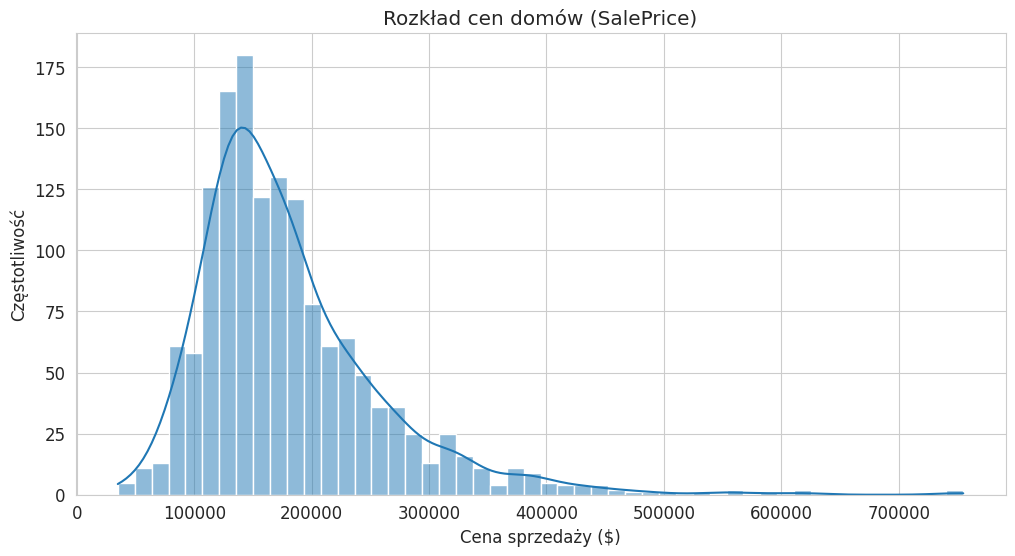

In [3]:
# Statystyki opisowe dla SalePrice
print("Statystyki opisowe dla ceny sprzedaży:")
print(train_df['SalePrice'].describe())

# Wizualizacja rozkładu SalePrice
plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Rozkład cen domów (SalePrice)')
plt.xlabel('Cena sprzedaży ($)')
plt.ylabel('Częstotliwość')
plt.show()

Obserwacja:
Rozkład SalePrice ma zauważalną dodatnią asymetrię (jest prawostronnie skośny, z długim "ogonem" w prawo).
Większość modeli liniowych działa lepiej z danymi o rozkładzie normalnym.
Działanie:
Zastosujemy transformację logarytmiczną (log1p), aby znormalizować rozkład.

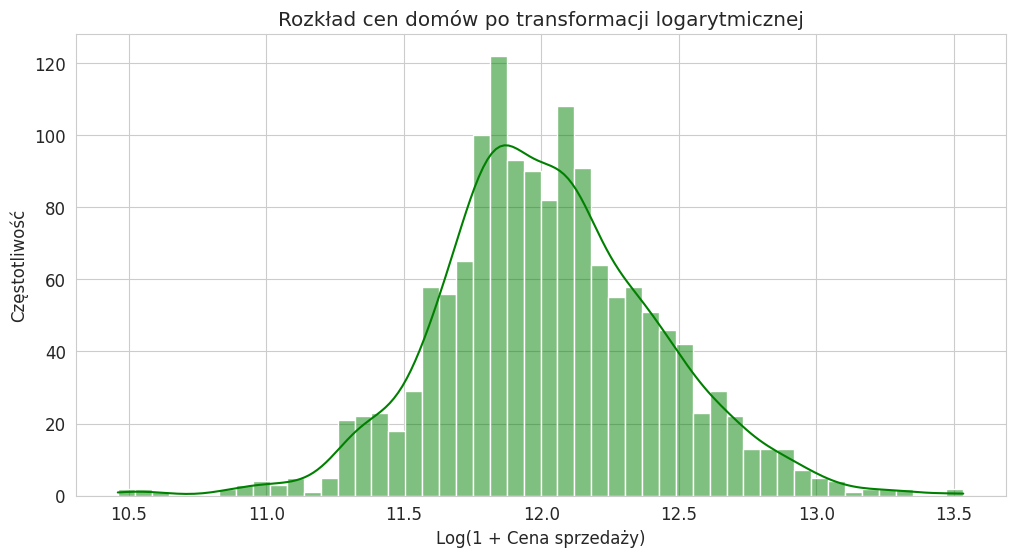

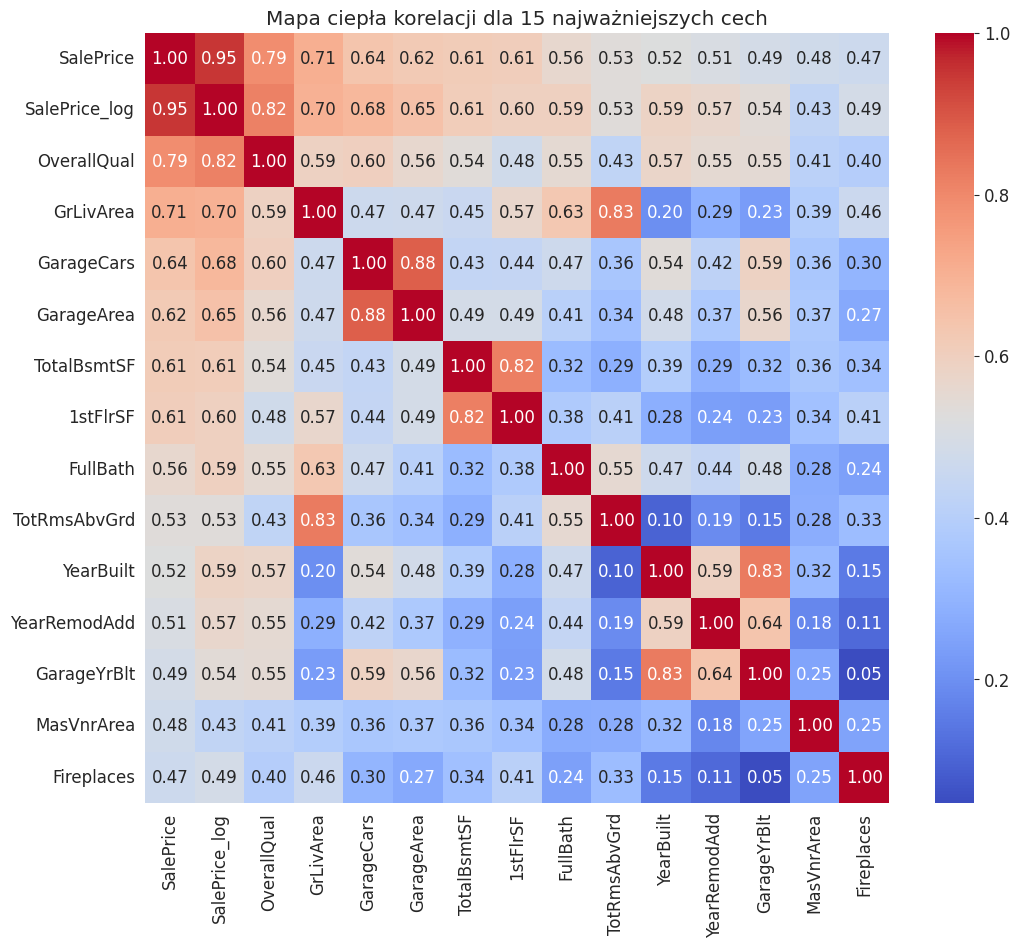

In [4]:
# Zastosowanie transformacji logarytmicznej
train_df['SalePrice_log'] = np.log1p(train_df['SalePrice'])

# Wizualizacja rozkładu po transformacji logarytmicznej
plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice_log'], kde=True, bins=50, color='green')
plt.title('Rozkład cen domów po transformacji logarytmicznej')
plt.xlabel('Log(1 + Cena sprzedaży)')
plt.ylabel('Częstotliwość')
plt.show()


# Wybieramy tylko kolumny numeryczne do obliczenia korelacji
numeric_cols = train_df.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

# Wybieramy 15 cech najbardziej skorelowanych z SalePrice
top_corr_features = corr_matrix.nlargest(15, 'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa ciepła korelacji dla 15 najważniejszych cech')
plt.show()

Obserwacje:
Największą dodatnią korelację z SalePrice mają:
OverallQual (Ogólna jakość materiałów i wykończenia)
GrLivArea (Powierzchnia mieszkalna nad poziomem gruntu)
GarageCars (Pojemność garażu w liczbie samochodów)
GarageArea (Powierzchnia garażu)
TotalBsmtSF (Całkowita powierzchnia piwnicy)
B. Wizualna analiza kluczowych cech
Przyjrzyjmy się bliżej najbardziej wpływowym cechom za pomocą wykresów.
Zbudujemy wykres pudełkowy (boxplot), aby zobaczyć, jak mediana ceny i rozrzut cen zmieniają się w zależności od oceny jakości domu.


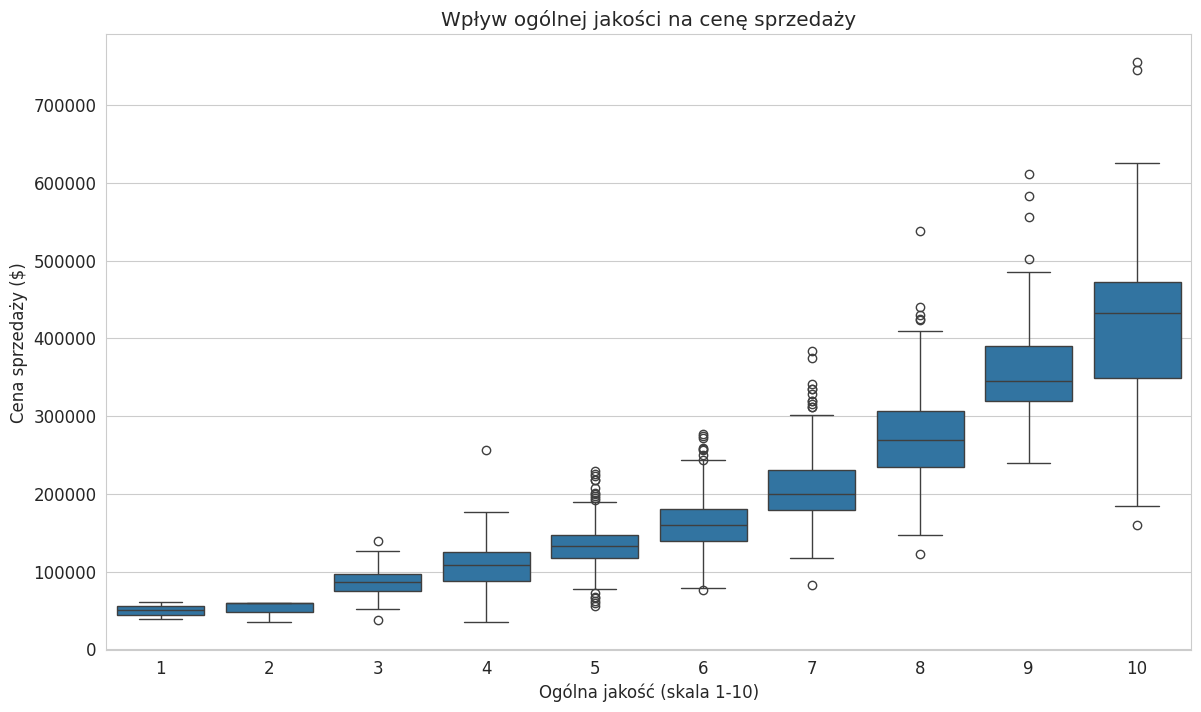

In [5]:
# Wykres pudełkowy dla OverallQual i SalePrice
plt.figure(figsize=(14, 8))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('Wpływ ogólnej jakości na cenę sprzedaży')
plt.xlabel('Ogólna jakość (skala 1-10)')
plt.ylabel('Cena sprzedaży ($)')
plt.show()

Wniosek: Istnieje silna dodatnia zależność. Im wyższa jakość domu, tym wyższa i bardziej stabilna jego cena.
Wykres rozrzutu (scatter plot) doskonale nadaje się do wizualizacji związku między dwiema zmiennymi numerycznymi.

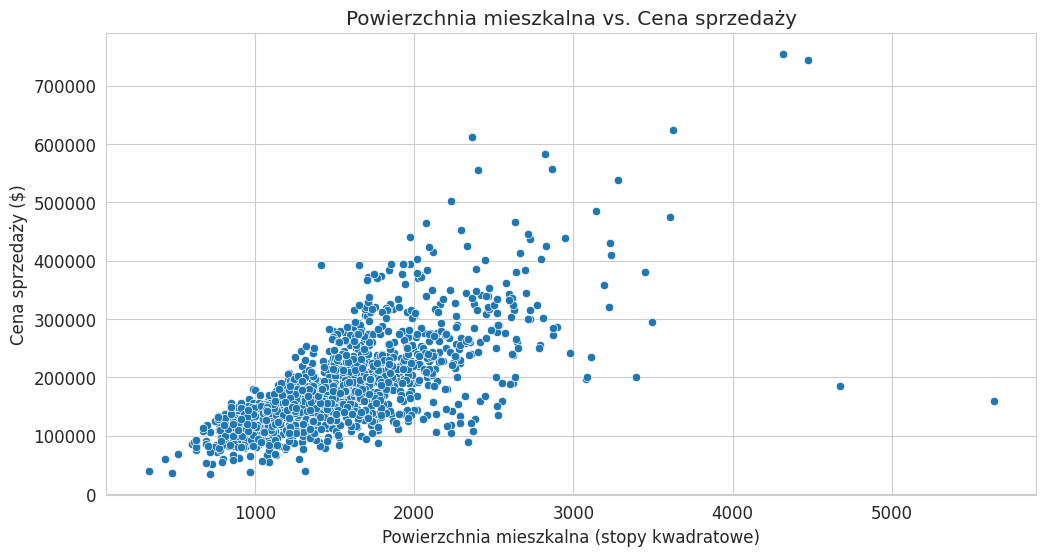

In [6]:
# Wykres rozrzutu dla GrLivArea i SalePrice
plt.figure(figsize=(12, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title('Powierzchnia mieszkalna vs. Cena sprzedaży')
plt.xlabel('Powierzchnia mieszkalna (stopy kwadratowe)')
plt.ylabel('Cena sprzedaży ($)')
plt.show()

Wniosek: Obserwujemy wyraźną zależność liniową: im większa powierzchnia, tym wyższa cena. Widoczne są również nieliczne wartości odstające — domy o bardzo dużej powierzchni, ale stosunkowo niskiej cenie. Warto je przeanalizować osobno.
Użyjemy boxplot do analizy tej cechy kategorycznej, ale uporządkowanej.

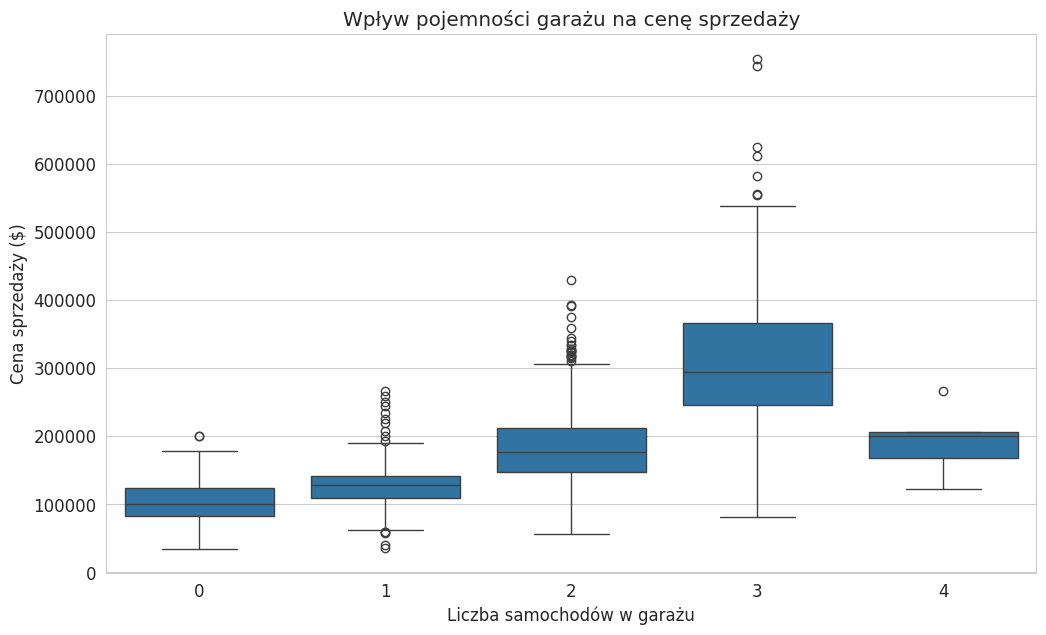

In [7]:
# Wykres pudełkowy dla GarageCars i SalePrice
plt.figure(figsize=(12, 7))
sns.boxplot(x='GarageCars', y='SalePrice', data=train_df)
plt.title('Wpływ pojemności garażu na cenę sprzedaży')
plt.xlabel('Liczba samochodów w garażu')
plt.ylabel('Cena sprzedaży ($)')
plt.show()

Wniosek: Cena rośnie wraz ze wzrostem pojemności garażu, ale po 3 samochodach ten wzrost ustaje. Jest to logiczne, ponieważ dla większości rodzin garaż na 4+ samochody jest nadmiarowy.
Lokalizacja jest jednym z najważniejszych czynników. Przeanalizujmy ceny według dzielnic.

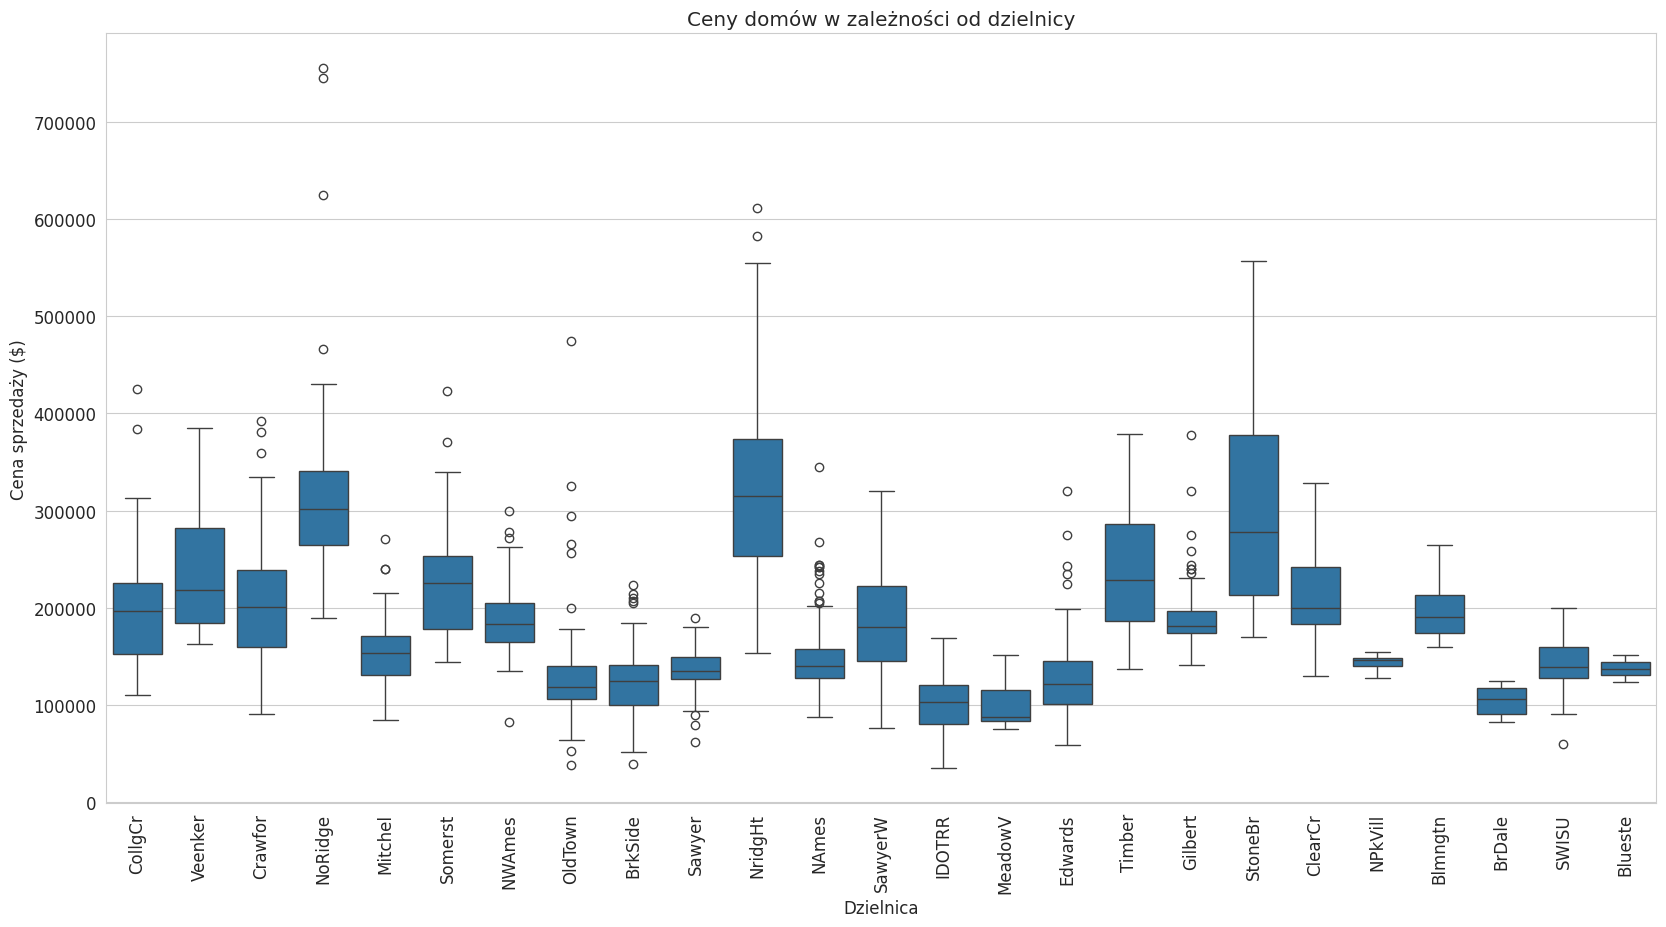

In [8]:
# Wykres pudełkowy dla Neighborhood i SalePrice
plt.figure(figsize=(20, 10))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df)
plt.title('Ceny domów w zależności od dzielnicy')
plt.xlabel('Dzielnica')
plt.ylabel('Cena sprzedaży ($)')
plt.xticks(rotation=90)
plt.show()

Wniosek: Na wykresie widać znaczną różnicę w cenach między dzielnicami. Cechy takie jak NridgHt, NoRidge i StoneBr są związane z najdroższymi domami.
Krok 4: Postępowanie z brakującymi wartościami
Ważnym etapem EDA jest znalezienie kolumn z brakującymi wartościami i zrozumienie, dlaczego ich brakuje.

Cechy z brakującymi wartościami:


,Liczba,Procent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageQual,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


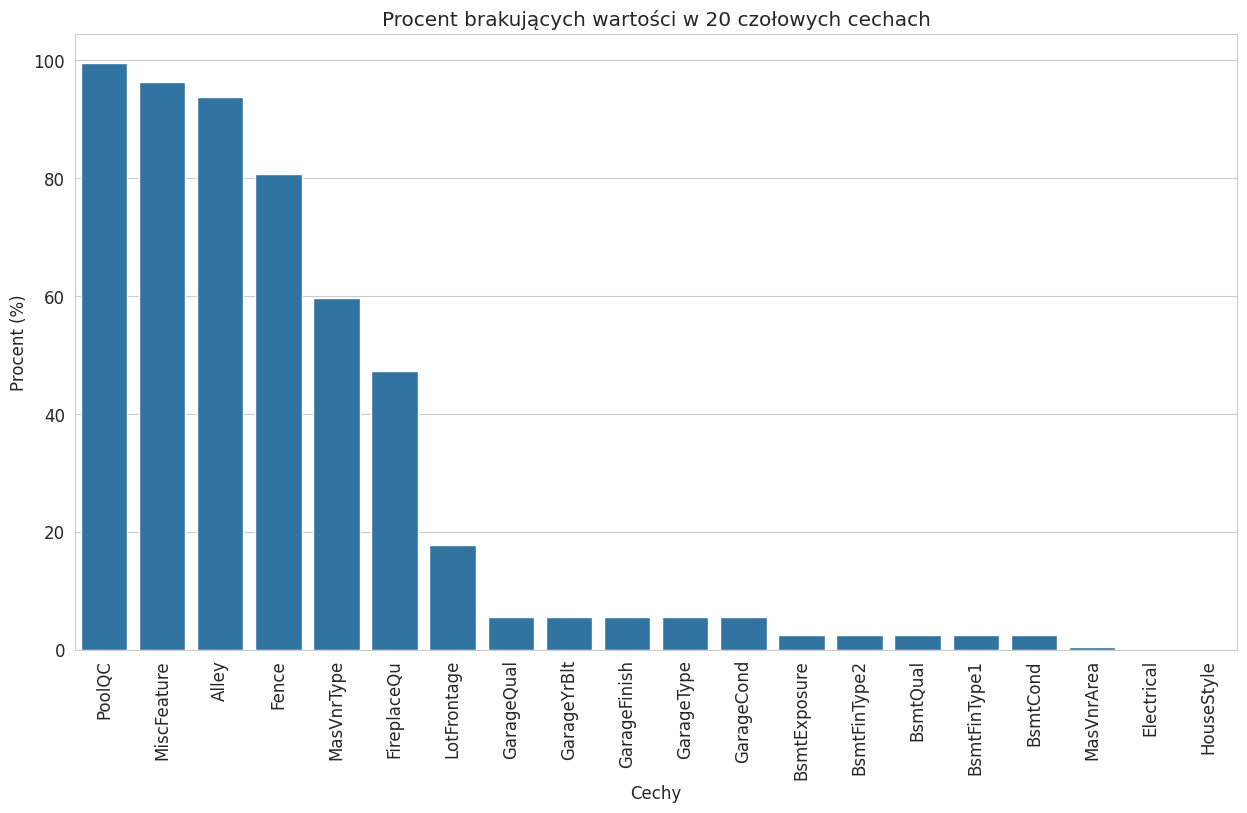

In [9]:
# Obliczanie procentu brakujących wartości
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(train_df)) * 100
missing_data = pd.concat([missing_values, missing_percent], axis=1, keys=['Liczba', 'Procent'])

# Wyświetlanie cech z brakującymi wartościami
print("Cechy z brakującymi wartościami:")
display(missing_data[missing_data['Liczba'] > 0])

# Wizualizacja brakujących wartości
plt.figure(figsize=(15, 8))
sns.barplot(x=missing_data.index[:20], y=missing_data['Procent'][:20])
plt.title('Procent brakujących wartości w 20 czołowych cechach')
plt.xlabel('Cechy')
plt.ylabel('Procent (%)')
plt.xticks(rotation=90)
plt.show()

Analiza:
Cechy PoolQC, MiscFeature, Alley, Fence mają bardzo dużo braków. Zgodnie z plikiem data_description.txt, NA w tych przypadkach oznacza nie brak danych, a brak samego obiektu (np. brak basenu lub ogrodzenia). Takie braki należy zastąpić kategorią "None".
LotFrontage (długość fasady) ma 17.7% braków. Prawdopodobnie te wartości można odtworzyć, używając mediany dla każdej dzielnicy (Neighborhood).
Braki w cechach związanych z garażem (GarageType, GarageYrBlt, GarageFinish itp.) lub piwnicą (BsmtQual, BsmtExposure itp.) najprawdopodobniej również oznaczają brak garażu lub piwnicy. Można je wypełnić zerami (dla cech numerycznych) lub kategorią "None" (dla kategorycznych).
Krok 5: Wnioski i następne kroki
Główne wnioski z EDA:
Zmienna docelowa (SalePrice) jest silnie asymetryczna i wymaga transformacji logarytmicznej do użycia w modelach liniowych.
Największy wpływ na cenę mają jakość wykonania (OverallQual) i powierzchnia mieszkalna (GrLivArea).
Charakterystyki garażu (liczba miejsc, powierzchnia) i piwnicy (całkowita powierzchnia) również są ważnymi predyktorami.
Lokalizacja (Neighborhood) — jeden z kluczowych czynników cenotwórczych.
W danych występują wartości odstające, które mogą negatywnie wpłynąć na model (np. domy o anomalnie dużej powierzchni i niskiej cenie).
Brakujące wartości w większości przypadków nie są błędem, a niosą informację (np. brak basenu), co trzeba będzie uwzględnić przy przetwarzaniu danych.